In [169]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch
from highlight_text import htext

In [170]:
base_url = 'https://understat.com/player/'
playerId = str(input('Please enter the match id: '))
url = base_url+playerId

Please enter the match id: 6345


In [171]:
#Use requests to get the webpage and BeautifulSoup to parse the page
res = requests.get(url)
soup = BeautifulSoup(res.content, 'lxml')
scripts = soup.find_all('script')

In [206]:
strings = scripts[4].string

In [207]:
strings

"\n\tvar matchesData\t= JSON.parse('\\x5B\\x7B\\x22goals\\x22\\x3A\\x221\\x22,\\x22shots\\x22\\x3A\\x222\\x22,\\x22xG\\x22\\x3A\\x220.7970735430717468\\x22,\\x22time\\x22\\x3A\\x2290\\x22,\\x22position\\x22\\x3A\\x22ML\\x22,\\x22h_team\\x22\\x3A\\x22Borussia\\x20Dortmund\\x22,\\x22a_team\\x22\\x3A\\x22Arminia\\x20Bielefeld\\x22,\\x22h_goals\\x22\\x3A\\x223\\x22,\\x22a_goals\\x22\\x3A\\x220\\x22,\\x22date\\x22\\x3A\\x222021\\x2D02\\x2D27\\x22,\\x22id\\x22\\x3A\\x2215339\\x22,\\x22season\\x22\\x3A\\x222020\\x22,\\x22roster_id\\x22\\x3A\\x22452201\\x22,\\x22xA\\x22\\x3A\\x220.4772578179836273\\x22,\\x22assists\\x22\\x3A\\x221\\x22,\\x22key_passes\\x22\\x3A\\x227\\x22,\\x22npg\\x22\\x3A\\x220\\x22,\\x22npxG\\x22\\x3A\\x220.03929685801267624\\x22,\\x22xGChain\\x22\\x3A\\x221.0667320489883423\\x22,\\x22xGBuildup\\x22\\x3A\\x220.6087691187858582\\x22\\x7D,\\x7B\\x22goals\\x22\\x3A\\x221\\x22,\\x22shots\\x22\\x3A\\x222\\x22,\\x22xG\\x22\\x3A\\x220.11822453886270523\\x22,\\x22time\\x22\\x3A\\x2

In [208]:
# strip unnecessary symbols and get only JSON data 
ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')

#convert string to json format
data = json.loads(json_data)

In [209]:
data

[{'goals': '1',
  'shots': '2',
  'xG': '0.7970735430717468',
  'time': '90',
  'position': 'ML',
  'h_team': 'Borussia Dortmund',
  'a_team': 'Arminia Bielefeld',
  'h_goals': '3',
  'a_goals': '0',
  'date': '2021-02-27',
  'id': '15339',
  'season': '2020',
  'roster_id': '452201',
  'xA': '0.4772578179836273',
  'assists': '1',
  'key_passes': '7',
  'npg': '0',
  'npxG': '0.03929685801267624',
  'xGChain': '1.0667320489883423',
  'xGBuildup': '0.6087691187858582'},
 {'goals': '1',
  'shots': '2',
  'xG': '0.11822453886270523',
  'time': '90',
  'position': 'AMR',
  'h_team': 'Schalke 04',
  'a_team': 'Borussia Dortmund',
  'h_goals': '0',
  'a_goals': '4',
  'date': '2021-02-20',
  'id': '15334',
  'season': '2020',
  'roster_id': '450841',
  'xA': '0.25165507197380066',
  'assists': '1',
  'key_passes': '2',
  'npg': '1',
  'npxG': '0.11822453886270523',
  'xGChain': '1.2189860343933105',
  'xGBuildup': '0.9692703485488892'},
 {'goals': '1',
  'shots': '1',
  'xG': '0.35427540540

In [151]:
x = []
y = []
result = []
xg = []
team = []
date = []
for i in data:
    x.append(i['X'])
    y.append(i['Y'])
    xg.append(i['xG'])
    result.append(i['result'])
    if i['h_a'] == 'h':
        team.append(i['h_team'])
    else:
        team.append(i['a_team'])
    date.append(i['date'])

In [152]:
col_names = ['x','y','xG','result','team','date']
df = pd.DataFrame([x,y,xg,result,team,date],index=col_names)
df = df.transpose()

In [153]:
df.date.dtype

dtype('O')

In [154]:
df = df[df['team'] == 'Borussia Dortmund']

In [155]:
df.reset_index(inplace=True)
df.drop('index',axis=1,inplace=True)

In [156]:
#Convert string values to float/int
df[['x','y','xG']] = df[['x','y','xG']].apply(pd.to_numeric)
df.x.dtype

#Adjust for pitch dimensions
df['x'] = df['x']*100
df['y'] = df['y']*100

#Swap x and y values as our pitch will be of vertical orientation
df['xx'] = df['y']
df['yy'] = df['x']

df['x'] = df['xx']
df['y'] = df['yy']

#Scale x and y values
df['x'] = df['x']*.8
df['y'] = df['y']*1.2


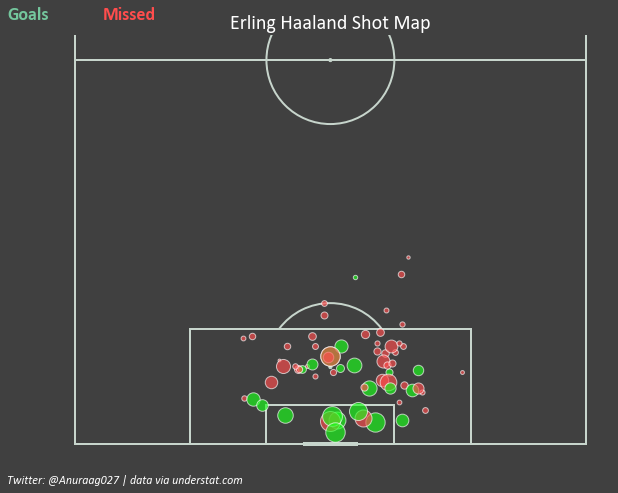

In [167]:
fig ,ax = plt.subplots(figsize=(13.5,8))
fig.set_facecolor('#404040')
ax.patch.set_facecolor('#404040')

#this is how we create the pitch
pitch = Pitch(pitch_type='statsbomb', orientation='vertical',
              pitch_color='#404040', line_color='#c7d5cc', figsize=(16,11),
              constrained_layout=True, tight_layout=False,view='half')

#Draw the pitch on the ax figure as well as invert the axis for this specific pitch
pitch.draw(ax=ax)
plt.gca().invert_yaxis()

goal_cnt = 0
for i in range(len(df['x'])):
    if df['result'][i] == 'Goal' and ('2020' in df['date'][i] or '2021' in df['date'][i]): #Goals scored
        if ('2020' in df['date'][i] and int(df['date'][i].split(' ')[0].split('-')[1]) >= 8):
            goal_cnt+=1
            plt.scatter(df['x'][i],df['y'][i],color='#1aff1a',s=df['xG'][i]*500,edgecolor='white',linewidth=1,alpha=.65)
        elif '2021' in df['date'][i]:
            goal_cnt+=1
            plt.scatter(df['x'][i],df['y'][i],color='#1aff1a',s=df['xG'][i]*500,edgecolor='white',linewidth=1,alpha=.65)            
    else: #Shots missed
        if ('2020' in df['date'][i] and int(df['date'][i].split(' ')[0].split('-')[1]) >= 8):
            plt.scatter(df['x'][i],df['y'][i],color='#ff4d4d',s=df['xG'][i]*500,edgecolor='white',linewidth=1,alpha=.65)
        elif '2021' in df['date'][i]:
            plt.scatter(df['x'][i],df['y'][i],color='#ff4d4d',s=df['xG'][i]*500,edgecolor='white',linewidth=1,alpha=.65)
htext.fig_text(s="<Goals>             <Missed>",
                x=0.18,y=0.9,
                highlight_weights=['bold'],
                #string_weight='bold',
                fontsize=18,
                fontfamily='Calibri',
                color='white',
                highlight_colors=['#74c69d','#ff4d4d'])
        
plt.title('Erling Haaland Shot Map',color='white',size=20,fontfamily='Calibri')
fig.text(.18,.1,"Twitter: @Anuraag027 | data via understat.com",fontstyle='italic',fontsize=12,fontfamily='Calibri',color='white')

plt.savefig('D:\Data Analysis TP\Erling Haaland 2020-21 shot map.png',dpi=300,bbox_inches = 'tight',facecolor="#404040")

In [168]:
print(goal_cnt)

21
